In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd /content/drive/MyDrive/Instruct_pix2pix

/content/drive/MyDrive/Instruct_pix2pix


# Setup

In [ ]:
!pip install datasets
!pip install xformers
!pip install bitsandbytes

In [8]:
import argparse
import logging
import math
import os
import glob
import json
from pathlib import Path
from typing import Optional
from easydict import EasyDict
from PIL import Image

import accelerate
import datasets
import diffusers
import numpy as np
import PIL
import requests
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from diffusers import (AutoencoderKL, DDPMScheduler,
                       StableDiffusionInstructPix2PixPipeline,
                       UNet2DConditionModel)
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, deprecate, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available
from huggingface_hub import HfFolder, Repository, create_repo, whoami
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

# Create Json

In [ ]:
# make_metadata.py
import os
import json
import glob

original_img_dir = './dataset/sketch/*.jpg' #Change to your original image directory path.
edited_img_dir = './dataset/color/*.jpg' #Change to your edited image directory path.

original_imgs = sorted(glob.glob(original_img_dir),key=lambda x: int(x.split('/')[-1].split('.')[0]))
edited_imgs = sorted(glob.glob(edited_img_dir),key=lambda x: int(x.split('/')[-1].split('.')[0]))

df = pd.read_csv('./dataset/edit_prompt.csv') #Change to your modified prompt csv file path
edit_prompts = df['modified_prompt'].to_list()

dataset = []

for original, edited, edit_prompt in zip(original_imgs, edited_imgs,edit_prompts):
    data_entry = {
        "original_image": original,
        "edited_image": edited,
        "edit_prompt": edit_prompt
    }
    dataset.append(data_entry)

# dataset
with open('metadata.jsonl', 'w', encoding='utf-8') as f:
    for entry in dataset:
        f.write(json.dumps(entry, ensure_ascii=False) + '\n')

print(f"Dataset creation complete! Total pairs: {len(dataset)}")

Dataset creation complete! Total pairs: 819


In [ ]:
with open('./dataset/metadata.jsonl', 'r') as f:
  json_data = [json.loads(line) for line in f]

In [ ]:
json_data[0]

{'original_image': './dataset/sketch/0.jpg',
 'edited_image': './dataset/color/0.jpg',
 'edit_prompt': 'Turn it into a vibrant and cheerful drawing of Bulbasaur, a green Pokémon with red eyes and a green tail, smiling amidst lush greenery, designed as a computer icon with a transparent background.'}

# Dataloader

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from transformers import CLIPTokenizer
from datasets import load_dataset
from accelerate import Accelerator

# Configs
pretrained_model_name_or_path = "timbrooks/instruct-pix2pix"
jsonl_path = "./dataset/metadata.jsonl"
resolution = 256
train_batch_size = 16
dataloader_num_workers = 0
max_train_samples = None
seed = 42
cache_dir = "./cache"
center_crop = False
random_flip = True

# Load dataset from .jsonl
dataset = load_dataset(
    "json",
    data_files={"train": jsonl_path},
    cache_dir=cache_dir
)

# Column name mapping
original_image_column = "original_image"
edit_prompt_column = "edit_prompt"
edited_image_column = "edited_image"
column_names = dataset["train"].column_names

# Load tokenizer
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer"
)

def tokenize_captions(captions):
    inputs = tokenizer(
        captions,
        max_length=tokenizer.model_max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    return inputs.input_ids

# Image transforms
train_transforms = transforms.Compose([
    transforms.CenterCrop(resolution) if center_crop else transforms.RandomCrop(resolution),
    transforms.RandomHorizontalFlip() if random_flip else transforms.Lambda(lambda x: x),
])

def preprocess_images(examples):
    original_images = np.concatenate([
        convert_to_np(path, resolution)
        for path in examples[original_image_column]
    ])
    edited_images = np.concatenate([
        convert_to_np(path, resolution)
        for path in examples[edited_image_column]
    ])
    images = np.concatenate([original_images, edited_images])
    images = torch.tensor(images)
    images = 2 * (images / 255) - 1
    return train_transforms(images)

def preprocess_train(examples):
    preprocessed_images = preprocess_images(examples)
    original_images, edited_images = preprocessed_images.chunk(2)
    original_images = original_images.reshape(-1, 3, resolution, resolution)
    edited_images = edited_images.reshape(-1, 3, resolution, resolution)

    examples["original_pixel_values"] = original_images
    examples["edited_pixel_values"] = edited_images

    captions = [caption for caption in examples[edit_prompt_column]]
    examples["input_ids"] = tokenize_captions(captions)
    return examples

# Accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=1,
    mixed_precision=None,
    log_with = "tensorboard",
    project_dir = "./logs"
)

# Apply preprocessing
with accelerator.main_process_first():
    if max_train_samples is not None:
        dataset["train"] = dataset["train"].shuffle(seed=seed).select(range(max_train_samples))
    train_dataset = dataset["train"].with_transform(preprocess_train)

# Collate function
def collate_fn(examples):
    original_pixel_values = torch.stack([ex["original_pixel_values"] for ex in examples]).float()
    original_pixel_values = original_pixel_values.to(memory_format=torch.contiguous_format)

    edited_pixel_values = torch.stack([ex["edited_pixel_values"] for ex in examples]).float()
    edited_pixel_values = edited_pixel_values.to(memory_format=torch.contiguous_format)

    input_ids = torch.stack([ex["input_ids"] for ex in examples])
    return {
        "original_pixel_values": original_pixel_values,
        "edited_pixel_values": edited_pixel_values,
        "input_ids": input_ids,
    }

# Dataloader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=train_batch_size,
    num_workers=dataloader_num_workers,
)

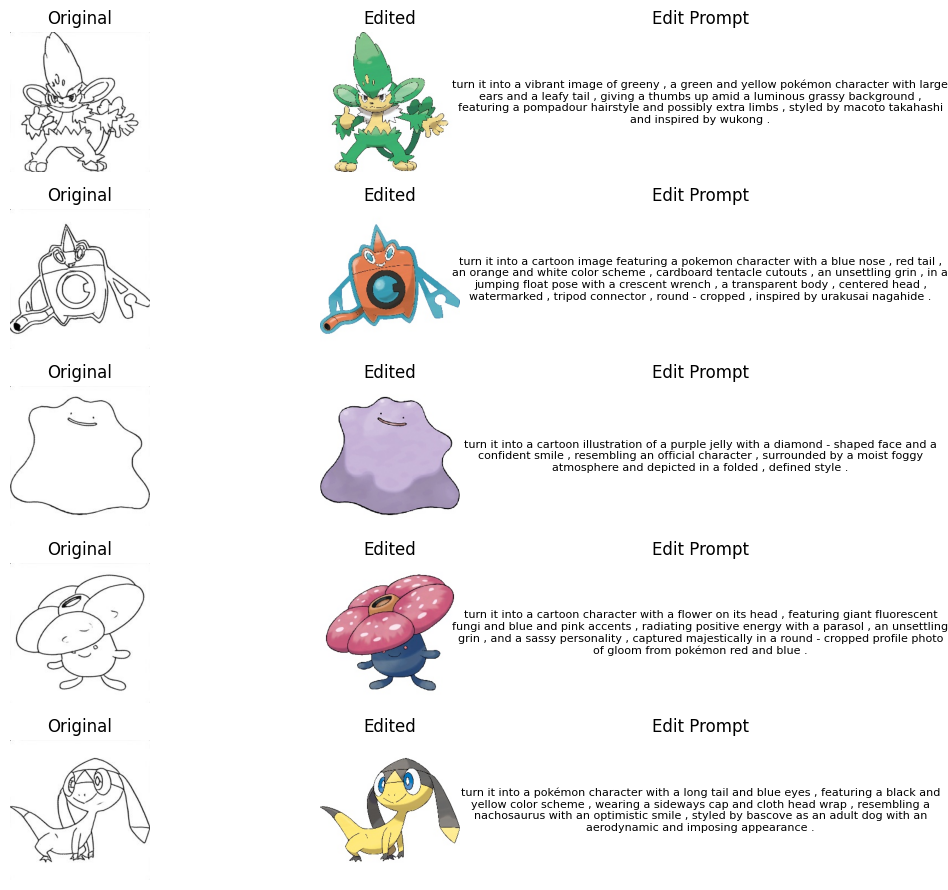

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from transformers import CLIPTokenizer


to_pil = T.ToPILImage()

tokenizer = CLIPTokenizer.from_pretrained("timbrooks/instruct-pix2pix", subfolder="tokenizer")

batch = next(iter(train_dataloader))

num_samples = 5

plt.figure(figsize=(10, 9))

for i in range(num_samples):
    # 이미지 복원 ([-1, 1] → [0, 1])
    original_img = (batch["original_pixel_values"][i] + 1) / 2
    edited_img = (batch["edited_pixel_values"][i] + 1) / 2

    # 텍스트 디코딩
    input_id = batch["input_ids"][i]
    decoded_text = tokenizer.decode(input_id, skip_special_tokens=True)

    # Original Image
    plt.subplot(num_samples, 3, i*3+1)
    plt.imshow(to_pil(original_img.cpu()))
    plt.title("Original")
    plt.axis("off")

    # Edited Image
    plt.subplot(num_samples, 3, i*3+2)
    plt.imshow(to_pil(edited_img.cpu()))
    plt.title("Edited")
    plt.axis("off")

    # Edit Prompt
    plt.subplot(num_samples, 3, i*3+3)
    plt.text(0.5, 0.5, decoded_text, fontsize=8, wrap=True, ha="center", va="center")
    plt.title("Edit Prompt")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Train
---
* colab환경이라, argparse대신에 easydict사용

In [ ]:
# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.15.0.dev0")

logger = get_logger(__name__, log_level="INFO")

WANDB_TABLE_COL_NAMES = ["original_image", "edited_image", "edit_prompt"]

def parse_args():
    args = EasyDict()
    args.pretrained_model_name_or_path = "timbrooks/instruct-pix2pix"
    args.revision = None
    args.train_data_dir = "dataset/metadata.jsonl"
    args.original_image_column ="original_image"
    args.edited_image_column = "edited_image"
    args.edit_prompt_column = "edit_prompt"
    args.val_image_url = None
    args.validation_prompt = None
    args.num_validation_images = 4
    args.validation_epochs = 1
    args.max_train_samples = None
    args.output_dir = "instruct_pix2pix_model"
    args.logging_dir = "logs"
    args.cache_dir = "cache"
    args.seed = 42
    args.resolution = 256
    args.center_crop = False
    args.random_flip = True
    args.train_batch_size = 16
    args.num_train_epochs = 100
    args.max_train_steps = None
    args.gradient_accumulation_steps = 1
    args.gradient_checkpointing = True
    args.learning_rate = 1e-4
    args.scale_lr = False
    args.lr_scheduler = "constant"
    args.lr_warmup_steps = 500
    args.conditioning_dropout_prob = None
    args.use_8bit_adam = True
    args.allow_tf32 = True
    args.use_ema = True
    args.non_ema_revision = None
    args.dataloader_num_workers = 0
    args.adam_beta1 = 0.9
    args.adam_beta2 = 0.999
    args.adam_weight_decay = 1e-2
    args.adam_epsilon = 1e-08
    args.max_grad_norm = 1.0
    args.push_to_hub = True
    args.hub_token = "Change to your HuggingFace API KEY"
    args.hub_model_id = None
    args.mixed_precision = None
    args.report_to = "tensorboard"
    args.local_rank = 1
    args.checkpointing_steps = 500
    args.checkpoints_total_limit = None
    args.resume_from_checkpoint = None
    args.enable_xformers_memory_efficient_attention = True

    # args = EasyDict()
    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if env_local_rank != -1 and env_local_rank != args.local_rank:
      args.local_rank = env_local_rank

    # Sanity checks
    if args.train_data_dir is None:
      raise ValueError("Need either a dataset name or a training folder.")

    # default to using the same revision for the non-ema model if not specified
    if args.non_ema_revision is None:
      args.non_ema_revision = args.revision

    return args


def get_full_repo_name(
    model_id: str, organization: Optional[str] = None, token: Optional[str] = None
):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"


def convert_to_np(image_path, resolution):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((resolution, resolution))
    return np.array(image).transpose(2, 0, 1)[None, ...]


def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image


def main():
    args = parse_args()

    if args.non_ema_revision is not None:
        deprecate(
            "non_ema_revision!=None",
            "0.15.0",
            message=(
                "Downloading 'non_ema' weights from revision branches of the Hub is deprecated. Please make sure to"
                " use `--variant=non_ema` instead."
            ),
        )

    logging_dir = os.path.join(args.output_dir, args.logging_dir)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_dir=logging_dir,
        # project_config=accelerator_project_config,
    )

    generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

    if args.report_to == "wandb":
        if not is_wandb_available():
            raise ImportError(
                "Make sure to install wandb if you want to use it for logging during training."
            )
        import wandb

    # Make one log on every process with the configuration for debugging.
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

    # If passed along, set the training seed now.
    if args.seed is not None:
        set_seed(args.seed)

    # Handle the repository creation
    if accelerator.is_main_process:
        if args.push_to_hub:
            if args.hub_model_id is None:
                repo_name = get_full_repo_name(
                    Path(args.output_dir).name, token=args.hub_token
                )
            else:
                repo_name = args.hub_model_id
            create_repo(repo_name, exist_ok=True, token=args.hub_token)
            repo = Repository(
                args.output_dir, clone_from=repo_name, token=args.hub_token
            )

            with open(os.path.join(args.output_dir, ".gitignore"), "w+") as gitignore:
                if "step_*" not in gitignore:
                    gitignore.write("step_*\n")
                if "checkpoint-*" not in gitignore:
                    gitignore.write("checkpoint-*\n")
                if "checkpoint-*" not in gitignore:
                    gitignore.write("checkpoint-*\n")

        elif args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)

    # Load scheduler, tokenizer and models.
    noise_scheduler = DDPMScheduler.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="scheduler"
    )
    tokenizer = CLIPTokenizer.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=args.revision,
    )
    text_encoder = CLIPTextModel.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=args.revision,
    )
    vae = AutoencoderKL.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision
    )
    unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="unet",
        revision=args.non_ema_revision,
    )

    # Freeze vae and text_encoder
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)

    # Create EMA for the unet.
    if args.use_ema:
        ema_unet = EMAModel(
            unet.parameters(), model_cls=UNet2DConditionModel, model_config=unet.config
        )

    if args.enable_xformers_memory_efficient_attention:
        if is_xformers_available():
            import xformers

            xformers_version = version.parse(xformers.__version__)
            if xformers_version == version.parse("0.0.16"):
                logger.warn(
                    "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
                )
            unet.enable_xformers_memory_efficient_attention()
        else:
            raise ValueError(
                "xformers is not available. Make sure it is installed correctly"
            )

    # `accelerate` 0.16.0 will have better support for customized saving
    if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
        # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
        def save_model_hook(models, weights, output_dir):
            if args.use_ema:
                ema_unet.save_pretrained(os.path.join(output_dir, "unet_ema"))

            for i, model in enumerate(models):
                model.save_pretrained(os.path.join(output_dir, "unet"))

                # make sure to pop weight so that corresponding model is not saved again
                weights.pop()

        def load_model_hook(models, input_dir):
            if args.use_ema:
                load_model = EMAModel.from_pretrained(
                    os.path.join(input_dir, "unet_ema"), UNet2DConditionModel
                )
                ema_unet.load_state_dict(load_model.state_dict())
                ema_unet.to(accelerator.device)
                del load_model

            for i in range(len(models)):
                # pop models so that they are not loaded again
                model = models.pop()

                # load diffusers style into model
                load_model = UNet2DConditionModel.from_pretrained(
                    input_dir, subfolder="unet"
                )
                model.register_to_config(**load_model.config)

                model.load_state_dict(load_model.state_dict())
                del load_model

        accelerator.register_save_state_pre_hook(save_model_hook)
        accelerator.register_load_state_pre_hook(load_model_hook)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Enable TF32 for faster training on Ampere GPUs,
    # cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
    if args.allow_tf32:
        torch.backends.cuda.matmul.allow_tf32 = True

    if args.scale_lr:
        args.learning_rate = (
            args.learning_rate
            * args.gradient_accumulation_steps
            * args.train_batch_size
            * accelerator.num_processes
        )

    # Initialize the optimizer
    if args.use_8bit_adam:
        try:
            import bitsandbytes as bnb
        except ImportError:
            raise ImportError(
                "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
            )

        optimizer_cls = bnb.optim.AdamW8bit
    else:
        optimizer_cls = torch.optim.AdamW

    optimizer = optimizer_cls(
        unet.parameters(),
        lr=args.learning_rate,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )

    # Load dataset from .jsonl
    dataset = load_dataset(
        "json",
        data_files={"train": args.train_data_dir},
        cache_dir=args.cache_dir
    )

    # Preprocessing the datasets.
    # We need to tokenize inputs and targets.
    column_names = dataset["train"].column_names

    def tokenize_captions(captions):
        inputs = tokenizer(
            captions,
            max_length=tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return inputs.input_ids

    # Image transforms
    train_transforms = transforms.Compose([
        transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
        transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
    ])

    def preprocess_images(examples):
        original_images = np.concatenate([
            convert_to_np(path, args.resolution)
            for path in examples[args.original_image_column]
        ])
        edited_images = np.concatenate([
            convert_to_np(path, args.resolution)
            for path in examples[args.edited_image_column]
        ])
        images = np.concatenate([original_images, edited_images])
        images = torch.tensor(images)
        images = 2 * (images / 255) - 1
        return train_transforms(images)

    def preprocess_train(examples):
        preprocessed_images = preprocess_images(examples)
        original_images, edited_images = preprocessed_images.chunk(2)
        original_images = original_images.reshape(-1, 3, args.resolution, args.resolution)
        edited_images = edited_images.reshape(-1, 3, args.resolution, args.resolution)

        examples["original_pixel_values"] = original_images
        examples["edited_pixel_values"] = edited_images

        captions = [caption for caption in examples[args.edit_prompt_column]]
        examples["input_ids"] = tokenize_captions(captions)
        return examples

    # Apply preprocessing
    with accelerator.main_process_first():
        if args.max_train_samples is not None:
            dataset["train"] = dataset["train"].shuffle(seed=args.seed).select(range(args.max_train_samples))
        train_dataset = dataset["train"].with_transform(preprocess_train)

    # Collate function
    def collate_fn(examples):
        original_pixel_values = torch.stack([ex["original_pixel_values"] for ex in examples]).float()
        original_pixel_values = original_pixel_values.to(memory_format=torch.contiguous_format)

        edited_pixel_values = torch.stack([ex["edited_pixel_values"] for ex in examples]).float()
        edited_pixel_values = edited_pixel_values.to(memory_format=torch.contiguous_format)

        input_ids = torch.stack([ex["input_ids"] for ex in examples])
        return {
            "original_pixel_values": original_pixel_values,
            "edited_pixel_values": edited_pixel_values,
            "input_ids": input_ids,
        }

    # Dataloader
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=collate_fn,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )

    # Scheduler and math around the number of training steps.
    overrode_max_train_steps = False
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
        overrode_max_train_steps = True

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    # Prepare everything with our `accelerator`.
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

    if args.use_ema:
        ema_unet.to(accelerator.device)

    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move text_encode and vae to gpu and cast to weight_dtype
    text_encoder.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    if overrode_max_train_steps:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    # Afterwards we recalculate our number of training epochs
    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        accelerator.init_trackers("instruct-pix2pix-cartoonizer", config=vars(args))

    # Train!
    total_batch_size = (
        args.train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(
        f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}"
    )
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    global_step = 0
    first_epoch = 0

    # Potentially load in the weights and states from a previous save
    if args.resume_from_checkpoint:
        if args.resume_from_checkpoint != "latest":
            path = os.path.basename(args.resume_from_checkpoint)
        else:
            # Get the most recent checkpoint
            dirs = os.listdir(args.output_dir)
            dirs = [d for d in dirs if d.startswith("checkpoint")]
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
            path = dirs[-1] if len(dirs) > 0 else None

        if path is None:
            accelerator.print(
                f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
            )
            args.resume_from_checkpoint = None
        else:
            accelerator.print(f"Resuming from checkpoint {path}")
            accelerator.load_state(os.path.join(args.output_dir, path))
            global_step = int(path.split("-")[1])

            resume_global_step = global_step * args.gradient_accumulation_steps
            first_epoch = global_step // num_update_steps_per_epoch
            resume_step = resume_global_step % (
                num_update_steps_per_epoch * args.gradient_accumulation_steps
            )

    # Only show the progress bar once on each machine.
    progress_bar = tqdm(
        range(global_step, args.max_train_steps),
        disable=not accelerator.is_local_main_process,
    )
    progress_bar.set_description("Steps")

    for epoch in range(first_epoch, args.num_train_epochs):
        unet.train()
        train_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            # Skip steps until we reach the resumed step
            if (
                args.resume_from_checkpoint
                and epoch == first_epoch
                and step < resume_step
            ):
                if step % args.gradient_accumulation_steps == 0:
                    progress_bar.update(1)
                continue

            with accelerator.accumulate(unet):
                # We want to learn the denoising process w.r.t the edited images which
                # are conditioned on the original image (which was edited) and the edit instruction.
                # So, first, convert images to latent space.
                latents = vae.encode(
                    batch["edited_pixel_values"].to(weight_dtype)
                ).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.num_train_timesteps,
                    (bsz,),
                    device=latents.device,
                )
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning.
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Get the additional image embedding for conditioning.
                # Instead of getting a diagonal Gaussian here, we simply take the mode.
                original_image_embeds = vae.encode(
                    batch["original_pixel_values"].to(weight_dtype)
                ).latent_dist.mode()

                # Conditioning dropout to support classifier-free guidance during inference. For more details
                # check out the section 3.2.1 of the original paper https://arxiv.org/abs/2211.09800.
                if args.conditioning_dropout_prob is not None:
                    random_p = torch.rand(
                        bsz, device=latents.device, generator=generator
                    )
                    # Sample masks for the edit prompts.
                    prompt_mask = random_p < 2 * args.conditioning_dropout_prob
                    prompt_mask = prompt_mask.reshape(bsz, 1, 1)
                    # Final text conditioning.
                    null_conditioning = text_encoder(
                        tokenize_captions([""]).to(accelerator.device)
                    )[0]
                    encoder_hidden_states = torch.where(
                        prompt_mask, null_conditioning, encoder_hidden_states
                    )

                    # Sample masks for the original images.
                    image_mask_dtype = original_image_embeds.dtype
                    image_mask = 1 - (
                        (random_p >= args.conditioning_dropout_prob).to(
                            image_mask_dtype
                        )
                        * (random_p < 3 * args.conditioning_dropout_prob).to(
                            image_mask_dtype
                        )
                    )
                    image_mask = image_mask.reshape(bsz, 1, 1, 1)
                    # Final image conditioning.
                    original_image_embeds = image_mask * original_image_embeds

                # Concatenate the `original_image_embeds` with the `noisy_latents`.
                concatenated_noisy_latents = torch.cat(
                    [noisy_latents, original_image_embeds], dim=1
                )

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(
                        f"Unknown prediction type {noise_scheduler.config.prediction_type}"
                    )

                # Predict the noise residual and compute loss
                model_pred = unet(
                    concatenated_noisy_latents, timesteps, encoder_hidden_states
                ).sample
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                # Gather the losses across all processes for logging (if we use distributed training).
                avg_loss = accelerator.gather(loss.repeat(args.train_batch_size)).mean()
                train_loss += avg_loss.item() / args.gradient_accumulation_steps

                # Backpropagate
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                if args.use_ema:
                    ema_unet.step(unet.parameters())
                progress_bar.update(1)
                global_step += 1
                accelerator.log({"train_loss": train_loss}, step=global_step)
                train_loss = 0.0

                if global_step % args.checkpointing_steps == 0:
                    if accelerator.is_main_process:
                        save_path = os.path.join(
                            args.output_dir, f"checkpoint-{global_step}"
                        )
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

            logs = {
                "step_loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        if accelerator.is_main_process:
            if (
                (args.val_image_url is not None)
                and (args.validation_prompt is not None)
                and (epoch % args.validation_epochs == 0)
            ):
                logger.info(
                    f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
                    f" {args.validation_prompt}."
                )
                # create pipeline
                if args.use_ema:
                    # Store the UNet parameters temporarily and load the EMA parameters to perform inference.
                    ema_unet.store(unet.parameters())
                    ema_unet.copy_to(unet.parameters())
                pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained(
                    args.pretrained_model_name_or_path,
                    unet=unet,
                    revision=args.revision,
                    torch_dtype=weight_dtype,
                )
                pipeline = pipeline.to(accelerator.device)
                pipeline.set_progress_bar_config(disable=True)

                # run inference
                original_image = download_image(args.val_image_url)
                edited_images = []
                with torch.autocast(
                    str(accelerator.device),
                    enabled=accelerator.mixed_precision == "fp16",
                ):
                    for _ in range(args.num_validation_images):
                        edited_images.append(
                            pipeline(
                                args.validation_prompt,
                                image=original_image,
                                num_inference_steps=20,
                                image_guidance_scale=1.5,
                                guidance_scale=7,
                                generator=generator,
                            ).images[0]
                        )

                for tracker in accelerator.trackers:
                    if tracker.name == "wandb":
                        wandb_table = wandb.Table(columns=WANDB_TABLE_COL_NAMES)
                        for edited_image in edited_images:
                            wandb_table.add_data(
                                wandb.Image(original_image),
                                wandb.Image(edited_image),
                                args.validation_prompt,
                            )
                        tracker.log({"validation": wandb_table})
                if args.use_ema:
                    # Switch back to the original UNet parameters.
                    ema_unet.restore(unet.parameters())

                del pipeline
                torch.cuda.empty_cache()

    # Create the pipeline using the trained modules and save it.
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unet = accelerator.unwrap_model(unet)
        if args.use_ema:
            ema_unet.copy_to(unet.parameters())

        pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            revision=args.revision,
        )
        pipeline.save_pretrained(args.output_dir)

        if args.push_to_hub:
            repo.push_to_hub(
                commit_message="End of training", blocking=False, auto_lfs_prune=True
            )

    accelerator.end_training()


if __name__ == "__main__":
    main()


# Test

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import torch
from diffusers import StableDiffusionInstructPix2PixPipeline
from diffusers.utils import load_image

In [6]:
def generation(checkpoint_path, image_path, prompt, result_path):
    pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained(
            checkpoint_path, torch_dtype=torch.float16,
            safety_checker = None,
            requires_safety_checker = False
        ).to("cuda:0")

    image = load_image(image_path)
    file_name = image_path.split('/')[-1]
    image = pipeline(prompt,image=image).images[0]

    os.makedirs(result_path, exist_ok=True)
    image.save(f'{result_path}/{file_name}')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

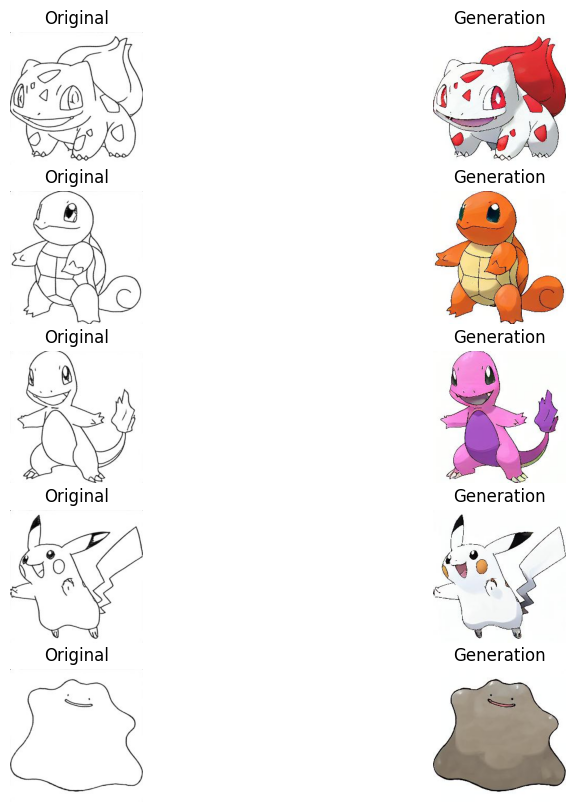

In [31]:
imgs = ["0.jpg", "759.jpg", "378.jpg", "186.jpg", "40.jpg"] #이상해씨, 꼬부기, 파이리, 피카츄, 메타몽
prompts = ['Turn it into a creature with a white belly and a red face and back.',
           'Turn it into a creature with a red tail and a orange belly and back.',
           'Turn it into a creature with a pink belly and a purple face and tail.',
           'Turn it into a creature with a white belly and a black tail.',
           'Turn it into a creature with a type of stone.']

checkpoint_path = "./instruct_pix2pix_model/"

plt.figure(figsize=(10,10))
for i, (img,prompt) in enumerate(zip(imgs,prompts)):
  generation(checkpoint_path=checkpoint_path,
             image_path = f'./dataset/sketch/{img}',
             prompt = prompt,
             result_path='./result')
  plt.subplot(5,2,i*2+1)
  plt.title('Original')
  plt.imshow(load_image(f'./dataset/sketch/{img}'))
  plt.axis('off')
  plt.subplot(5,2,i*2+2)
  plt.title('Generation')
  plt.imshow(load_image(f'./result/{img}'))
  plt.axis('off')